In [15]:
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import xarray as xr
import pyart
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from pyhail import hdr, mesh_grid, mesh_ppi, common, hsda, hacc
import matplotlib.colors as colors
import shapefile as shp
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from netCDF4 import Dataset, num2date, date2num
import wrf
from matplotlib.cm import get_cmap
from datetime import datetime
from pprint import pprint
from pysteps import io, motion, nowcasts, rcparams, verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver
import os, glob, csv, geopandas
from matplotlib_scalebar.scalebar import ScaleBar
from geodatasets import get_path
from pandas import *
import tempfile, glob, shutil, os
from netCDF4 import Dataset
from wrf import getvar, ll_to_xy, CoordPair, GeoBounds, ALL_TIMES

warnings.filterwarnings('ignore')


In [16]:
def Cal_u_v(direction_data, speed_data):
    pi = 3.14159265359
    com = -np.abs(speed_data)
    u_com = com*np.sin(pi*np.array(direction_data)/180)
    v_com = com*np.cos(pi*np.array(direction_data)/180)
    return u_com, v_com
def read_sounding(file_in):
    num=0
    f = open(file_in, 'r+')
    press = []
    temp = []
    dew_p = []
    speed = []
    height = []
    direction = []
    for line in f:
        num+=1
        if (num>=6):
            press.append(float(line.split()[0]))
            temp.append(float(line.split()[2]))
            dew_p.append(float(line.split()[3]))

            speed.append(float(line.split()[7]))
            height.append(float(line.split()[1]))
            direction.append(float(line.split()[6]))
    f.close()
    u_com, v_com = Cal_u_v(direction, speed)
    return press, height, temp, dew_p, u_com, v_com

def _adjust_ncarpid_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the hydrometeor classification.
    """
    cb.set_ticks(np.linspace(0.5, 19.5, 20))
    cb.ax.set_yticklabels(
        [
        "nodata","Cloud","Drizzle","Light_Rain","Moderate_Rain",
            "Heavy_Rain","Hail","Rain_Hail_Mixture",
            "Graupel_Small_Hail","Graupel_Rain","Dry_Snow",
            "Wet_Snow", "Ice_Crystals", "Irreg_Ice_Crystals",
           "Supercooled_Liquid_Droplets", "Flying_Insects",
            "Second_Trip", "Ground_Clutter","misc1", "misc2"
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def _adjust_hsda_scheme_colorbar_for_pyart(cb):
    """
    Generate colorbar for the HSDA classification.
    """
    cb.set_ticks(np.linspace(0, 3, 4))
    cb.ax.set_yticklabels(
        [
            "None",
            "SH (<25mm)",
            "LH (25-50mm)",
            "GH (>50mm)",
        ]
    )
    cb.ax.set_ylabel("")
    cb.ax.tick_params(length=0)
    return cb

def build_cmaps():
    """
    This function retruns the discrete colourmaps used
    in the pipeline
    """
    hca_colors = [
        "White", #no data
        "lightgray", #cloud
        "LightBlue", #drizzle
        "SteelBlue", #light rain
        "RoyalBlue", #moderate rain
        "Navy", #heavy rain
        "fuchsia", #hail
        "darkviolet", #rain hail
        "hotpink", #Graupel_Small_Hail
        "crimson", #Graupel_Rain
        "lightgreen", #Dry_Snow 
        "limegreen", #Wet_Snow
        "green", #Ice_Crystals
        "seagreen", #Irreg_Ice_Crystals
        "Red", #Supercooled_Liquid_Droplets
        "orange", #Flying_Insects
        "chocolate", #Second_Trip
        "sienna", #Ground_Clutter
        "cyan", #misc1
        "teal", #misc2 
        ]
    hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
    hca_cmap = colors.ListedColormap(hca_colors)  
    hsda_cmap = colors.ListedColormap(hsda_colors) 
    return hca_cmap, hsda_cmap

In [43]:
def plt_binary(subplot_idx, field, title=None, lonlat=None):
    ax=plt.subplot(subplot_ncols,subplot_nrows,subplot_idx)
    #fig, ax = plt.subplots(figsize=(6,6))
    basemap = Basemap(
            llcrnrlon=min_lon,
            llcrnrlat=min_lat,
            urcrnrlon=max_lon,
            urcrnrlat=max_lat,
            #lat_0=lat_0[0],
            #lon_0=lon_0[0],
            projection="merc",
            ax=ax
            )
    parallels = np.arange(20.,25.,0.5)
    meridians = np.arange(102.,105.,0.5)
    basemap.drawparallels(parallels, labels=[True,False,False,True])
    basemap.drawmeridians(meridians, labels=[True,False,False,True])

    basemap.readshapefile(shp_vn, "shapefile", ax=ax)
    hca_cmap, hsda_cmap = build_cmaps()
    cs = basemap.contourf(lons, lats, field, latlon=True, levels=np.arange(-0.5, 4.5, 1), cmap=hsda_cmap, ax=ax)

    #cs = basemap.contourf(lons,lats,field,latlon=True,
    #                  levels=np.arange(-0.5,4.5,1), cmap=hsda_cmap)
                      #cbar_kwargs={'pad':0.02,'shrink':0.8})
#cbar = basemap.colorbar(cs,location='bottom',pad="5%")
#cbar.set_label("HSDA")
#ax.grid()
#print(ax)
#gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
    
    if lonlat is not None:
        lat_hail, lon_hail = zip(*lonlat)
        x_hail, y_hail = basemap(lon_hail, lat_hail)
        ax.scatter(x_hail, y_hail, marker='x', color='black') #, label='Hail Marker')
    ax.set_title(None)
    
    scale1 = ScaleBar(
            dx=1,
            location="lower left",  # in relation to the whole plot
            label_loc="left",
            scale_loc="bottom",  # in relation to the line
             )
    ax.add_artist(scale1)

def plt_fss(subplot_idx, fss, skill, plt_legend=True, plt_ylabel=True):
    z = np.arange(120)
    ax=plt.subplot(subplot_ncols,subplot_nrows,subplot_idx)
    plt.ylim(0,1)
    plt.xlim(1,119)
    plt.plot(z,skill,linestyle='dashed', color='k')
    plt.plot(z,fss)
    if plt_legend:
        plt.legend(name, loc = "lower right")
    #plt.xlabel("Scale (points)")
    if plt_ylabel:
        plt.ylabel("FSS ( > 5 mm ) ")
    #plt.title("Fractions skill score MP08 "+str(i))

In [18]:
def create_fields(radar,refl_field="corrected_reflectivity"):
	#radar.add_field("temperature", temp_dict, 
    #replace_existing=True)
	#radar.add_field("height", z_dict, replace_existing=True)
	hca_meta = pyart.retrieve.hydroclass_semisupervised(
		radar,
		refl_field="reflectivity",
		zdr_field="differential_reflectivity",
		kdp_field="specific_differential_phase",
		rhv_field="cross_correlation_ratio",
		temp_field="temperature",
		)
	radar.add_field("radar_echo_classification", hca_meta,
                    replace_existing=True)

	snr = radar.fields['differential_phase'].copy()
	radar.add_field('signal_to_noise_ratio', snr,
                    replace_existing=True)
	cbb_meta = {'data':np.zeros_like(
                radar.fields[refl_field]['data']),
                'units': '%','description': "dummy field",
				'long_name': 'cumulative beam blocking percentage',
				'comment': ""}
	radar.add_field('cbb', cbb_meta, replace_existing=True)

	mesh_ppi_meta = mesh_ppi.main(radar, refl_field , levels=[dbt_0C, dbt_minus20C], min_range=10, max_range=150, mesh_method='mh2019_75')
	ke_meta = mesh_ppi_meta['hail_ke'].copy()
	radar.add_field('KE', ke_meta, replace_existing=True)
	shi_meta = mesh_ppi_meta['shi'].copy()
	radar.add_field('SHI', shi_meta, replace_existing=True)
	mesh_meta = mesh_ppi_meta['mesh_mh2019_75'].copy()
	radar.add_field('MESH', mesh_meta, replace_existing=True)
	posh_meta = mesh_ppi_meta['posh'].copy()
	radar.add_field('POSH', posh_meta, replace_existing=True)

	dbz = radar.fields[refl_field]['data']
	zdr = radar.fields['differential_reflectivity']['data']
	radar_dict = {'dbz':dbz, 'zdr':zdr}
	hdr_meta, hdr_size_meta = hdr.main(radar_dict)
	radar.add_field('hdr', hdr_meta, replace_existing=True)
	radar.add_field('hdr_size', hdr_size_meta, replace_existing=True)

	hsda_meta = hsda.main(radar, [wbt_0C, wbt_minus25C], hca_hail_idx,
                          zh_name=refl_field, zdr_name="differential_reflectivity",
                          phi_name="differential_phase",cbb_name="cbb")
	radar.add_field('HSDA', hsda_meta, replace_existing=True)

	hacc_meta = hacc.main(radar, wbt_0C, pressure_correction, z_fname=refl_field, hsda_fname='HSDA', mesh_fname='MESH')
	radar.add_field('hacc', hacc_meta, replace_existing=True)
	return radar

############################################################################################
#
#	Part 0. Initial case
#
############################################################################################
#####	Define case

In [19]:
#####	Calculate raw field of radar
def read_radar():
    print("Reading radar data for case: ", date[case])
    #####	Assign radar data list name
    nf = 0
    a = []
    f0 = fd_radar[case]
    for h in range(12):	# Doc 12h radar, tu 04z00 den 19z50   
        h0 = h + 6          # bat dau tu 06z
        for m in range(6):	#(6):		# 6 file 1 gio
        	m0  = m*10
        	m00 = str(m0)
        	if m0 == 0:
        		m00 = "00"
        	h00 = str(h0)
        	if h0 <= 9:
        		h00 = "0" + str(h0)
        	t0 = h00 + m00
        	f1 = f0 + fn_radar[case] + t0 + "*"
        	a.append(f1)

    
    for file_raw in a:
    	b = glob.glob(file_raw)
    	if b != []:
    		nf = nf + 1
	#file_raw = "./data/20200317/PHADIN/PHA200317235246.RAWPPCD"
	#file_raw = "./data/20200422/PHA200422110004.RAWSAEC"
	#file_raw = "./data/PHA200317113004.RAWPNJG"
	#_utc_time = "PHA210321163004"
#	_utc_time = file_raw[19:29]		#20200422
    		_utc_time = file_raw[slen[case]:elen[case]]		
            #20200317
    		print(_utc_time)
    		radar0 = pyart.io.read_sigmet(file_raw)
    		z_dict, temp_dict = pyart.retrieve.map_profile_to_gates(
                temp,height,radar0)
    		radar0.add_field("temperature", temp_dict,
                             replace_existing=True)
    		radar0.add_field("height", z_dict,
                             replace_existing=True)
    		radar = create_fields(radar0,refl_field="reflectivity")

#####   Calculate mesh grid radar object
#	radar site RR = 300km
#	1.5km resolution: ndims = "(21,601,601)" 
#nrange = "((0.,20000.),(-300000.,300000.),(-300000.,300000.))"

    		grid = pyart.map.grid_from_radars(radar,ndims,nmax, 
                                  weighting_function='NEAREST',
                                  fields=fld)
    		if nf == 1:
    			xgrid = grid.to_xarray()
    		
    		xgrid0 = grid.to_xarray()
    		xgrid  = xr.concat([xgrid,xgrid0],dim='time')
            # ntime x nz x ny x nx  (ntime toan bo chuoi)

    xg      = xgrid.isel(time=slice(1,None))
    hour	= xg.time.dt.hour
    rd_hour = np.arange(hour[0],hour[-1]+1,1)
    #print(hour[0],hour[-1])
    
    minu	= xg.time.dt.minute
    xg		= xg.assign_coords(hour=("time",hour.data),
                               minu=("time",minu.data))
    xg 		= xg.set_index(time=("hour","minu")).unstack("time")

#####   Define grid object

    lat_grid = grid.point_latitude['data']
    lon_grid = grid.point_longitude['data']
    lon_0 = grid.origin_longitude['data']
    lat_0 = grid.origin_latitude['data']

    xg = xg.assign_coords(lon=("x",lon_grid[0,0,:]))
    xg = xg.assign_coords(lat=("y",lat_grid[0,:,0]))
    xg = xg.swap_dims({"x": "lon"})
    xg = xg.swap_dims({"y": "lat"})
    return xg, rd_hour

In [20]:
#   Get wrf grid data  
####   
def read_wrf(minlat, minlon, maxlat, maxlon):
    print("Reading WRF data for case: ", date[case])
    fd0	= fd_wrf[case]
    fn0	= fn_wrf[case]

    nhour  = len(rd_hour)
    hour = rd_hour
    # number of available radar hour
    #deltah = list(range(0,nhour)) 
    deltah = [0,1,2,3,4,5]
    #list of aval. range merged hour

    HC_mask = np.empty([4,nhour,nhour,len(lats[:,0]),len(lons[0,:])])
    UH_mask = np.empty([4,nhour,nhour,len(lats[:,0]),len(lons[0,:])])
    CT_mask = np.empty([4,nhour,nhour,len(lats[:,0]),len(lons[0,:])])
    HM_mask = np.empty([4,nhour,nhour,len(lats[:,0]),len(lons[0,:])])
    HC_mask1 = np.empty([4,len(lats[:,0]),len(lons[0,:])])
    UH_mask1 = np.empty([4,len(lats[:,0]),len(lons[0,:])])
    CT_mask1 = np.empty([4,len(lats[:,0]),len(lons[0,:])])
    HM_mask1 = np.empty([4,len(lats[:,0]),len(lons[0,:])])

    ll = CoordPair(lat=minlat, lon=minlon)
    ur = CoordPair(lat=maxlat, lon=maxlon)
    bounds = GeoBounds(ll, ur)

    for mp00 in range(4):
        combine = []
        mp0	= mp[case][mp00]
        tempdir = "./wrf/convert1/" + str(mp0) + "/"
        if mp0 != nullmp:
#fn0 = "./reduced_wrfout_d03_2020-03-17_"
            print(date[case], "- MP" + mp0)
            for h in range(12): # Doc 12h wrf, tu 07z00 den 18z50
            	h0 = h + 7      # bat dau tu 07z
            	if h0 in hour:
                    #print(h0)
                    h1 = str(h0)
                    if h0 < 10:
                        h1 = "0" + str(h0)
                    t0 = h1 + ":00:00"
                    f1 = fd0 + mp0 + fn0 + t0
                    combine.append(f1)
#combine = [Dataset("reduced_wrfout_d03_2020-03-17_12:00:00"),
#            Dataset("reduced_wrfout_d03_2020-03-17_13:00:00")]
            #print(combine)
            reduced_files = FileReduce(combine, bounds, 
                                       tempdir=tempdir, 
                                       delete=True, 
                                       reuse=True)

            HC = wrf.getvar(reduced_files,"HAILCAST_DIAM_MAX",timeidx=wrf.ALL_TIMES,method="cat")  
            # HAILCAST_DIAM_MAX
            UH = wrf.getvar(reduced_files,"UP_HELI_MAX", timeidx=wrf.ALL_TIMES, method="cat")        
            # UPDRAFT HELICITY
            CT = wrf.getvar(reduced_files,"GRPL_MAX", timeidx=wrf.ALL_TIMES, method="cat") 
            # COLUMN INTEGRATED TOTAL GRAUPEL  
            HM = wrf.getvar(reduced_files,"HAIL_MAXK1", timeidx=wrf.ALL_TIMES, method="cat")         
            # THOMPSON HAIL

            max_UH = UH.max(axis=0) 
            max_CT = CT.max(axis=0)
            max_HM = HM.max(axis=0)
            max_HC = HC.max(axis=0)

            HC_MASK_050 = xr.where(max_HC >= 5,1,0)
            UH_MASK_050 = xr.where(max_UH >= 25,1,0)
            CT_MASK_050 = xr.where(max_CT >= 5,1,0)
            HM_MASK_050 = xr.where(max_HM >= 5,1,0)
    
            HC_MASK_250 = xr.where(max_HC >= 25,1,0)
            UH_MASK_250 = xr.where(max_UH >= 75,1,0)
            CT_MASK_250 = xr.where(max_CT >= 25,1,0)
            HM_MASK_250 = xr.where(max_HM >= 25,1,0)

            HC_MASK_500 = xr.where(max_HC >= 50,1,0)
            UH_MASK_500 = xr.where(max_UH >= 150,1,0)
            CT_MASK_500 = xr.where(max_CT >= 50,1,0)
            HM_MASK_500 = xr.where(max_HM >= 50,1,0)

            HCmask1 = HC_MASK_050 + HC_MASK_250 + HC_MASK_500
            UHmask1 = UH_MASK_050 + UH_MASK_250 + UH_MASK_500
            CTmask1 = CT_MASK_050 + CT_MASK_250 + CT_MASK_500
            HMmask1 = HM_MASK_050 + HM_MASK_250 + HM_MASK_500

            HC_mask1[mp00,:,:] = HCmask1
            UH_mask1[mp00,:,:] = UHmask1
            CT_mask1[mp00,:,:] = CTmask1
            HM_mask1[mp00,:,:] = HMmask1
###	This command getting WRF coordinate to interpolate
            #lats, lons = wrf.latlon_coords(HC)
    
### After this line, all value converted to 4 levels: 
#   no hail (value = 0); nonservere d>5mm (value = 1), 
#   severe 25mm<d<5mm (value = 2) and sign. severe d>50mm(value = 3)

#print(lats, lons)
    return HC_mask1, UH_mask1, CT_mask1, HM_mask1

In [21]:
## #	Interpolate radar data to WRF grid 
#   Input: xg, rd_hour (from radar); lats, lons (from wrf)
def interp_to_wrf_grid():
    print("Interpolate radar grid to WRF grid")

    #    Get some arguments:
    min_lat = lats[0,0]
    min_lon = lons[0,0]
    max_lat = lats[-1,-1]
    max_lon = lons[-1,-1]

    nhour = len(rd_hour)
    hour = rd_hour
    #nhour  = int(np.asarray(rd_hour[-1] - rd_hour[0] + 1))
    # number of available radar hour
    #hour   = list(range(np.asarray(rd_hour[0])
    #                    ,np.asarray(rd_hour[-1]+1))) 
    #list of aval. radar hour
    #deltah = list(range(0,nhour))  
    deltah = [0,1,2,3,4,5]
    #list of aval. range merged hour
    #ndh[:] = nhour + 1 - dh[:]

    # Khai bao
    MESH_max  = np.empty([len(lats[:,0]),len(lons[0,:])])
    HSDA_max  = np.empty([len(lats[:,0]),len(lons[0,:])])
    HSDA0_max = np.empty([len(lats[:,0]),len(lons[0,:])])

    ##
    xgrid2 			= xg.sel(lat=slice(min_lat,max_lat),
                             lon=slice(min_lon,max_lon))
    xgrid_interp 	= xgrid2.interp(lat=lats,lon=lons)
    npgrid_interp 	= xgrid_interp.as_numpy()

    HSDA0 = npgrid_interp['HSDA']
    HSDA_hmax = HSDA0.max(axis=4)               
    #getiing maximum by hour 
    MESH0 = npgrid_interp['MESH']
    MESH_hmax = MESH0.max(axis=0).max(axis=3)    
    #getting maximum by hour & beam

    MESH_max  = MESH_hmax.max(axis=2)
    HSDA0_max = HSDA_hmax[0,:,:,:].max(axis=2)
    HSDA_max  = HSDA_hmax.max(axis=0).max(axis=2)


    MESH_MASK_05 = xr.where(MESH_max >= 5,1,0)
    MESH_MASK_25 = xr.where(MESH_max >= 25,1,0)
    MESH_MASK_50 = xr.where(MESH_max >= 50,1,0)

    MESH_mask0 = MESH_MASK_05 + MESH_MASK_25 + MESH_MASK_50  
    HSDA_mask0 = HSDA0_max

    HSDA_mask  = np.round(HSDA_mask0,0)       #lam tron
    MESH_mask  = np.round(MESH_mask0,0)
    HSDA_max0  = np.round(HSDA_max,0)

#print(UH_max)
    return MESH_mask, HSDA_mask, HSDA_max0      
# MESH 0/1; HSDA 0/1 for 0.5 deg. beam, 
# HSDA 0/1 maximum over radar beam

In [22]:
def dimsize_domain(minlat, minlon, maxlat, maxlon):
    #input: Lonlat boundary
    #output: wrf domain dimsize
    #print(minlat, minlon, maxlat, maxlon)
    ll = CoordPair(lat=minlat, lon=minlon)
    ur = CoordPair(lat=maxlat, lon=maxlon)
    bounds = GeoBounds(ll, ur)
    ftest = [	"./wrf/raw/2020031612/mp.008/wrfout_d03_2020-03-16_12:00:00" ]
    #     		"wrfout_d03_2020-03-16_13:00:00" ]	
    reduced_files = FileReduce(ftest, bounds, tempdir="./wrf/convert2/", delete=True, reuse=True)
    slp = getvar(reduced_files, "slp",timeidx=ALL_TIMES)
    lats, lons = wrf.latlon_coords(slp)

    return lats, lons

In [23]:
class FileReduce(object):
    def __init__(self, filenames, geobounds, tempdir=None, delete=True, reuse=False):
        """An iterable object for cutting out geographic domains.
        
        Args:
        
            filenames (sequence): A sequence of file paths to the WRF files
            
            geobounds (GeoBounds): A GeoBounds object defining the region of interest
            
            tempdir (str): The location to store the temporary cropped data files. If None, tempfile.mkdtemp is used.
            
            delete (bool): Set to True to delete the temporary directory when FileReduce is garbage collected.
            
            reuse (bool): Set to True when you want to resuse the files that were previously converted. *tempdir* 
                must be set to a specific directory that contains the converted files and *delete* must be False.
        
        """
        self._filenames = filenames
        self._i = 0
        self._geobounds = geobounds
        self._delete = delete
        self._cache = set()
        self._own_data = True
        self._reuse = reuse
        
        if tempdir is not None:
            if not os.path.exists(tempdir):
                os.makedirs(tempdir)
            self._tempdir = tempdir
            if self._reuse:
                self._cache = set((os.path.join(self._tempdir, name) 
                                   for name in os.listdir(self._tempdir)))
        else:
            self._tempdir = tempfile.mkdtemp()

        #print ("temporary directory is: {}".format(self._tempdir))
        self._prev = None
        self._set_extents()

    def _set_extents(self):
        fname = list(self._filenames)[0]
        with Dataset(fname) as ncfile:
            lons = [self._geobounds.bottom_left.lon, self._geobounds.top_right.lon]
            lats = [self._geobounds.bottom_left.lat, self._geobounds.top_right.lat]
            orig_west_east = len(ncfile.dimensions["west_east"])
            orig_south_north = len(ncfile.dimensions["south_north"])
            
            
            # Note: Not handling the moving nest here
            # Extra points included around the boundaries to ensure domain is fully included
            x_y = ll_to_xy(ncfile, lats, lons, meta=False)
            self._start_x = 0 if x_y[0,0] == 0 else x_y[0,0] - 1
            self._end_x = orig_west_east - 1 if x_y[0,1] >= orig_west_east - 1 else x_y[0,1] + 1
            self._start_y = 0 if x_y[1,0] == 0 else x_y[1,0] - 1
            self._end_y = orig_south_north - 1 if x_y[1,1] >= orig_south_north - 1 else x_y[1,1] + 1
            
            self._west_east = self._end_x - self._start_x + 1
            self._west_east_stag = self._west_east + 1
            self._south_north = self._end_y - self._start_y + 1
            self._south_north_stag = self._south_north + 1
      
    def __iter__(self):
        return self
    
    def __copy__(self):
        cp = type(self).__new__(self.__class__)
        cp.__dict__.update(self.__dict__)
        cp._own_data = False
        cp._delete = False
        
        return cp
    
    def __del__(self):
        if self._delete:
            shutil.rmtree(self._tempdir)
    
    def reduce(self, fname):
        outfilename = os.path.join(self._tempdir, "reduced_" + os.path.basename(fname))
        #print(outfilename)
        
        # WRF-Python can iterate over sequences several times during a 'getvar', so a cache is used to 
        if outfilename in self._cache:
            return Dataset(outfilename)
        
        # New dimension sizes
        dim_d = {"west_east" : self._west_east,
                 "west_east_stag" : self._west_east_stag,
                 "south_north" : self._south_north,
                 "south_north_stag" : self._south_north_stag
                }
        
        # Data slice sizes for the 2D dimensions
        slice_d = {"west_east" : slice(self._start_x, self._end_x + 1),
                   "west_east_stag" : slice(self._start_x, self._end_x + 2),
                   "south_north" : slice(self._start_y, self._end_y + 1),
                   "south_north_stag" : slice(self._start_y, self._end_y + 2)
                  }
        
        with Dataset(fname) as infile, Dataset(outfilename, mode="w") as outfile:
            #print ("reduce getting called!")
            
            # Copy the global attributes
            outfile.setncatts(infile.__dict__)

            # Copy Dimensions, limiting south_north and west_east to desired domain
            for name, dimension in infile.dimensions.items():
                dimsize = dim_d.get(name, len(dimension))
                outfile.createDimension(name, dimsize)

            # Copy Variables 
       #     print(infile.variables) 
            for name, variable in infile.variables.items():
                new_slices = tuple((slice_d.get(dimname, slice(None)) for dimname in variable.dimensions))

                outvar = outfile.createVariable(name, variable.datatype, variable.dimensions)

                outvar[:] = variable[new_slices]

                outvar.setncatts(variable.__dict__)
                
        
        result = Dataset(outfilename)
            
        self._cache.add(outfilename)
        #print(outfilename)    
        return result
            
    
    def next(self):
        if self._i >= len(self._filenames):
            if self._prev is not None:
                self._prev.close()
            raise StopIteration
        else:
            fname = self._filenames[self._i]
            reduced_file = self.reduce(fname)
            if self._prev is not None:
                self._prev.close()
            self._prev = reduced_file
            
            self._i += 1
            
            return reduced_file
    
    # Python 3
    def __next__(self):
        return self.next()


In [24]:
# How to use with getvar
# Set lower left and upper right to your desired domain
#ll = CoordPair(lat=20.753, lon=102.505)
#ur = CoordPair(lat=22.749, lon=104.494)

#ll = CoordPair(lat=20, lon=102)
#ur = CoordPair(lat=23, lon=105)
#bounds = GeoBounds(ll, ur)
#a = [	"wrfout_d03_2020-03-16_12:00:00" ,
#		"wrfout_d03_2020-03-16_13:00:00" ]	
#reduced_files = FileReduce(a,
#                    bounds, tempdir="./", delete=True, reuse=True)
#slp = getvar(reduced_files, "slp",timeidx=ALL_TIMES)



In [25]:
casename = [ '2401', '1703', '2403', '2204' ]
date	= [ '2020-01-24', '2020-03-17', '2020-03-24', '2020-04-22' ]
mp		= [ [ '008', '009', '101', '102' ],
			[ '008', '009', '101', '102' ],
			[ '008', '009', '101', '102' ],
			[ '008', '000', '101', '000' ] ]
nullmp 	= '000'
fd_wrf 	= ["./wrf/raw/2020012312/mp.",
           "./wrf/raw/2020031612/mp.",
           "./wrf/raw/2020032312/mp.",
           "./wrf/raw/2020042112/mp." ]
fn_wrf  = [ "/wrfout_d03_2020-01-24_", 
			"/wrfout_d03_2020-03-17_",
			"/wrfout_d03_2020-03-24_",
			"/wrfout_d03_2020-04-22_" ]

snd		= ['48820_202001241200.txt',
           '48820_202003170000.txt',
           '48820_202003241200.txt',
           '48820_202004221200.txt']
fd_radar = ["./radar/data/20200124/",
            "./radar/data/20200317/PHADIN/",
            "./radar/data/20200324/",
            "./radar/data/20200422/" ]
slen	= [ 25, 32, 25, 25 ]
elen 	= [ 35, 42, 35, 35 ]
fn_radar = [ 'PHA200124','PHA200317','PHA200324','PHA200422' ]

h0_rd = [ 5, 10, 11, 9  ]
h1_rd = [ 9, 18, 15, 12 ]
nhour_rd = [ 4, 8, 4, 3 ]

maxlat = 22.75
minlat = 20.75
maxlon = 104.5
minlon = 102.5

#   Parameter
hca_hail_idx = [6, 7, 8]
shp_vn = "./radar/gadm40_VNM_1"
#max_lat = 22.75
#min_lat = 20.75
#min_lon = 102.5
#max_lon = 104.5
#####	Assign some variable
com_grid={}
com_grid['lonmin']=102.5
com_grid['lonmax']=104.5
com_grid['latmin']=20.75
com_grid['latmax']=22.75
com_grid['reslu_horiz']=801
com_grid['reslu_vert']=21
bbox = [101,17,109,25]
d_lon = 801
d_lat = 801

ndims = (21, 401, 401)
nmax = ((0.,20000.),(-300000.,300000.),(-300000.,300000.))
fld = ['MESH','radar_echo_classification','HSDA']
nf = 0

#scales = [2, 10, 20, 40, 53, 60, 120]
scales = list(range(1,121))
scale2 = [5, 10, 20, 40, 60, 80, 119]
thr = 1.0     # nonsevere > 5mm
###########################################

case = 1


#################################################################################################
#											MAIN												#
#################################################################################################
#
#								Part I. Calculate radar object 
#
#################################################################################################

In [38]:
latlon_hail = [ [21.587328229809298, 103.41423468374727],       # Tuần Giáo, Điện Biên
           [21.520144081260202, 103.23773985937177],        #Mường Ảng, ĐB
           [21.44373045152829, 103.12140419664722],         # Mường Phăng (tp ĐB)
           [21.456237383279454, 102.96051457454125],        #Thanh Nưa (tp ĐB)
           [21.20573107961421, 102.95438041231975],         #Hua Thanh (DB)
           [22.232490126436325, 103.72175608332748],        # Phúc Khoa (LChau)
          # [22.154925671510323, 103.7675840409492],         #Thân Thuộc (LChau) trùng Trung Đồng
           [22.026021472564853, 103.68368799863003],        #Tà Mít (Lchau)
           [22.204604076996795, 103.69924977810805],        # Mường Khoa (Lchau)
           [22.152828741801542, 103.771555653507],          #Trung Đồng (Lchau)
           [22.463637599523153, 103.36877076960953],        # Lả Nhì Thàng (Lchau)
           [22.358524187761347, 103.24933139524744],        #Sìn Hồ (LChau)
           [20.856235097633984, 104.61888920864101],        #Mộc châu (Sl)
           [20.81054230267168, 104.77805699523958],         #Vân Hồ (SL)
           [21.198874889559992, 104.09856783832277],        # Mai Sơn (SL)
           [21.658324264497573, 103.6231540187663],         #Quỳnh Nhai (SL)
           [21.441547823918096, 103.70941749013859],        # Thuận Châu (SL)
           [21.51769185330874, 104.02971981138884],         # Mường La (SL)
           [20.93770478894486, 103.59568837357833],         #Sốp Cộp (SL)
           [21.326850050270775, 103.91634393956616],        #tp Sơn La
           [22.03856744347442, 104.49236137583809],         #Châu Quế Hạ (YB)
           [22.236074162849146, 104.47545017519882],        #TT Phố ràng (LCai)
           [22.187443979138347, 104.4968955880311],         #Lương Sơn (Lcai)
           [22.18487704169275, 104.54337916844946],         #Long Phúc (Lcai)
           [22.187253807650958, 104.57217722766158],        #Long Khánh (LCai)
           [22.175033079631937, 104.35476208626902],        #Bảo Hà (Lcai)
           [22.339407356934437, 103.84167711653187],        #Sa Pa (Lcai)
           [22.541579324094815, 103.69732206397404],        #Bát Xát (Lcai)
           [22.687397907587677, 104.26723633471387],        #Si Ma Cai (Lcai)


          ]
           
           


In [27]:
fss = verification.get_method("FSS")
ncase = 4
lats, lons = dimsize_domain(minlat, minlon, maxlat, maxlon)

m_HSDA = np.empty([4,len(lats[:,0]),len(lons[0,:])])
m_MESH = np.empty([4,len(lats[:,0]),len(lons[0,:])])

m_UH = np.empty([4,4,len(lats[:,0]),len(lons[0,:])])
m_HC = np.empty([4,4,len(lats[:,0]),len(lons[0,:])])



for icase in range(ncase):
#####   Read sounding
    #case = 3
    case = icase
    file_sounding = "./radar/" + snd[case]
    _, height, temp, _, _, _ = read_sounding(file_sounding)

    snd_p = np.loadtxt(file_sounding, usecols=1,
                       skiprows=4, dtype=int )
    snd_z = np.loadtxt(file_sounding, usecols=2,
                       skiprows=4, dtype=int )
    snd_t = np.loadtxt(file_sounding, usecols=3,
                       skiprows=4, dtype=int )
    snd_r = np.loadtxt(file_sounding, usecols=5,
                       skiprows=4, dtype=int )

#	dry bulb calcs for MESH
    dbt_minus20C = common.sounding_interp(snd_t, snd_z,-20)
    dbt_0C       = common.sounding_interp(snd_t, snd_z,0)
#	wet bulb calcs for HSDA
    snd_wbt      = common.wbt(snd_t,snd_r)
    wbt_minus25C = common.sounding_interp(snd_wbt,snd_z,-25)
    wbt_0C       = common.sounding_interp(snd_wbt,snd_z,0)
#	pressure correction
    prs_wbt_0C 	= common.sounding_interp(snd_wbt,snd_p,0)
    mean_pres 	= (snd_p[0]+ prs_wbt_0C)/2.
    pressure_correction = pow(1000./mean_pres,0.545)

#######################################################

    #rd_iname = fn_radar[case] + ".nc"
    #rd_fin   = Dataset(rd_iname,'r')
    #HSDA_mask = []
    #MESH_mask = []
    #HSDA_mask = rd_fin.variables['HSDA_mask']
    #MESH_mask = rd_fin.variables['MESH_mask']
    #lons1 = rd_fin.variables['lon']
    #lats1 = rd_fin.variables['lat']
    #print(lons1)
    #m_HSDA[icase,:,:]  = xr.where(HSDA_mask[:] < 4,HSDA_mask[:],0).max(axis = 0).max(axis=0)
    #m_MESH[icase,:,:]  = MESH_mask[:].max(axis = 0).max(axis=0)
    #print(max_HSDA.shape)

    
    #hour = rd_fin.variables['hour'][:]
    
    #merge_hour = ([np.asarray(hour[-1]-hour[0]+1),
     #              int(hour[0]), int(hour[-1]) ])
    #nhour = int(merge_hour[0])
    #list_hour = np.arange(int(merge_hour[0])) 
    # So gio thuc te cua moi range dh
    #deltah = list(range(nhour+1))
    xg,rd_hour = read_radar()
    
    HC_mask1, UH_mask1, CT_mask1, HM_mask1 = read_wrf(minlat, minlon, maxlat, maxlon)
    MESH_mask, HSDA_mask, HSDA_max = interp_to_wrf_grid()

    m_UH[case,:,:,:] = UH_mask1
    m_HC[case,:,:,:] = HC_mask1

    m_HSDA[case,:,:] = HSDA_mask
    m_MESH[case,:,:] = MESH_mask
    
###############################################################
    # Đọc mỗi ngày gồm:
    # Output: 1 day radar to wrf grid, 4 mp wrf grid

    # wrf data:  n_mp x n_delta_h x n_hour x nx x ny
    # radar data:       n_delta_h x n_hour x nx x ny

########################################

    #dhmax = deltah[-1]  # chi tinh cho 1 - dhmax gio lan can
    #print(hour)
    #print(UH_mask.shape)

    #############################################
    
    #rd_fin.close();


   

Reading radar data for case:  2020-01-24
2001240600
2001240610
2001240620
2001240630
2001240640
2001240650
2001240700
2001240710
2001240720
2001240730
2001240740
2001240750
2001240800
2001240810
2001240820
2001240830
2001240840
2001240850
2001240900
Reading WRF data for case:  2020-01-24
2020-01-24 - MP008
2020-01-24 - MP009
2020-01-24 - MP101
2020-01-24 - MP102
Interpolate radar grid to WRF grid
Reading radar data for case:  2020-03-17
2003171000
2003171010
2003171020
2003171030
2003171040
2003171050
2003171100
2003171110
2003171120
2003171130
2003171140
2003171150
2003171200
2003171210
2003171220
2003171230
2003171240
2003171250
2003171300
2003171310
2003171320
2003171330
2003171340
2003171350
2003171400
2003171410
2003171420
2003171430
2003171440
2003171450
2003171500
2003171510
2003171520
2003171530
2003171540
2003171550
2003171600
2003171610
2003171620
2003171630
2003171640
2003171650
2003171700
2003171710
2003171720
2003171730
2003171740
2003171750
Reading WRF data for case:  202

In [28]:
print(rd_hour)
print(minlat, minlon, maxlat, maxlon)
print(lons)

[ 9 10 11 12]
20.75 102.5 22.75 104.5
<xarray.DataArray 'XLONG' (south_north: 157, west_east: 146)>
array([[102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105],
       [102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105],
       [102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105],
       ...,
       [102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105],
       [102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105],
       [102.49276 , 102.50673 , 102.5207  , ..., 104.490166, 104.504135,
        104.518105]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 102.5 102.5 102.5 ... 104.5 104.5
    XLAT      (south_north, west_east) float32 20.74 20.74 20.74 ... 22.76 22.76
    XTIME     float64 0.0
    Time      datetime64[ns] 2020-03-16T12:00:00
    datetime  datetime64[ns] 2020-03-16T12:00:00
Dimension

(4, 4, 157, 146)


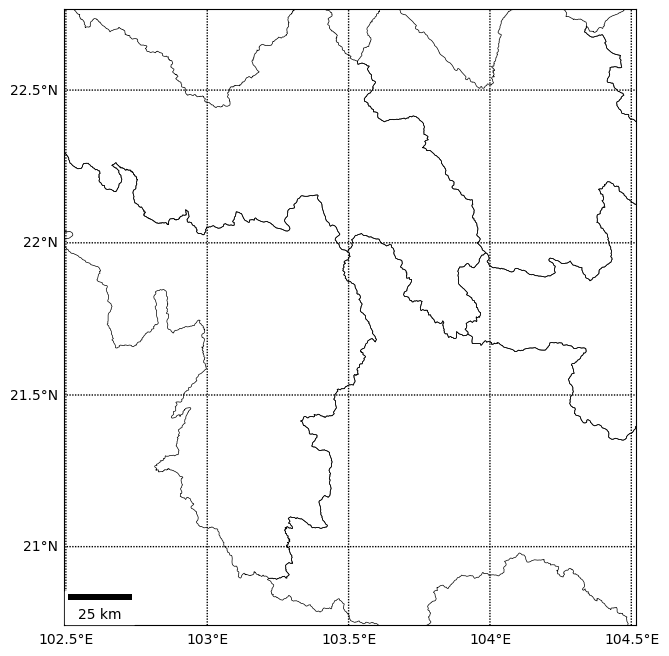

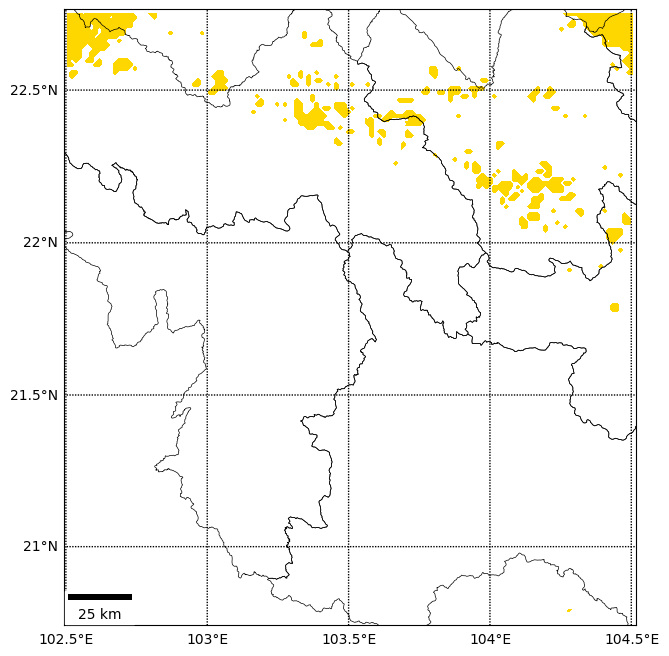

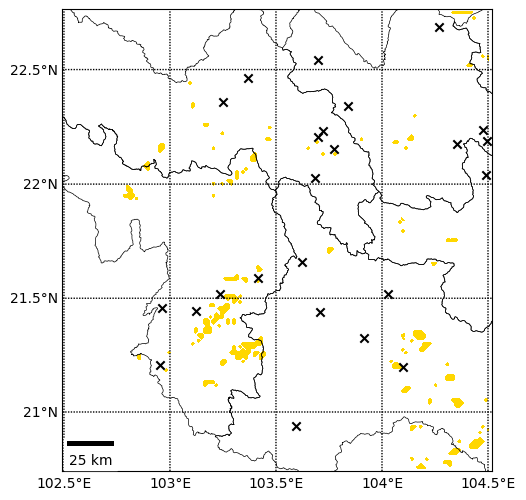

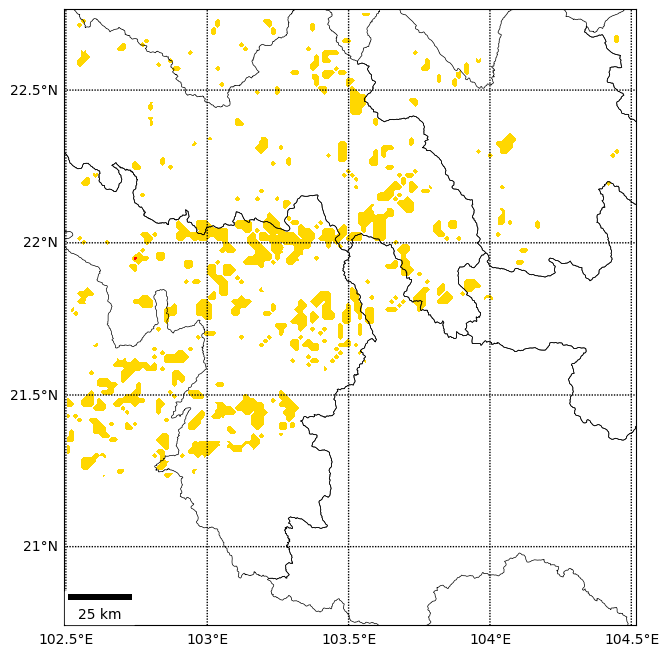

done


In [45]:
min_lat = lats[0,0]
min_lon = lons[0,0]
max_lat = lats[-1,-1]
max_lon = lons[-1,-1]

print(m_HC.shape)
#print(lats[:,0])
#print(lons[0,:])

subplot_ncols = 1
subplot_nrows = 1
fig = plt.figure(figsize=[8,8])
plt_binary(1,m_HSDA[0,:,:])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.show()
fname = "hsda.c01.png"
fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.close()
fig = plt.figure(figsize=[8,8])
plt_binary(1,m_HSDA[1,:,:])
plt.show()
fname = "hsda.c02.png"
fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.close()

fig = plt.figure(figsize=[6,6])
plt_binary(1,m_HSDA[2,:,:],lonlat=latlon_hail)
plt.show()
fname = "hsda.c003.png"
fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.close()

fig = plt.figure(figsize=[8,8])
plt_binary(1,m_HSDA[3,:,:])
plt.show()
fname = "hsda.c04.png"
fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
fname = "mp10.HC.png"
#fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.close()
print("done")

In [30]:
for aaaaa in range(1):
    rd_oname = "/work/users/duydm/Detai/TN.22.13/" + "hsda_radar_all.nc"
    ncout = Dataset(rd_oname,'w','NETCDF4')
    ncout.createDimension('lat',len(lats[:,0]));
    ncout.createDimension('lon',len(lons[0,:]));
    ncout.createDimension('mp',4);
    #ncout.createDimension('hour',len(avail_hour));
    #ncout.createDimension('time', None)
    #time = ncout.createVariable('time', 'str', ('time'))
    #time.long_name = 'time'
    #time.units = 'hours'
    #time.calendar = 'standard'
    #time.axis = 'T'
    #time[:] = "2020-03-17"
    
    #ncout.createDimension('beam',21);
    lonvar  = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lons[0,:];
    latvar  = ncout.createVariable('lat','float32',('lat'));latvar[:] = lats[:,0];
    #dhvar   = ncout.createVariable('deltah','float32',('deltah'));dhvar[:] = deltah[:];
    #hvar    = ncout.createVariable('hour','float32',('hour'));hvar[:] = avail_hour[:];
    #beamvar = ncout.createVariable('beam','float32',('beam'));beamvar[:] = list(arange(21));
    
    HSDAmask = ncout.createVariable('m_HSDA','float32',('mp','lat','lon'));m_HSDA[:] = m_HSDA[:];
    #HSDAmax  = ncout.createVariable('HSDA_max','float32',('deltah','hour','lat','lon')); HSDAmax[:]  = HSDA_max[:];
    #MESHmask = ncout.createVariable('MESH_mask','float32',('deltah','hour','lat','lon'));MESHmask[:] = MESH_mask[:];
    ncout.close();
    print("Successfully create hail data file: .nc")

Successfully create hail data file: .nc


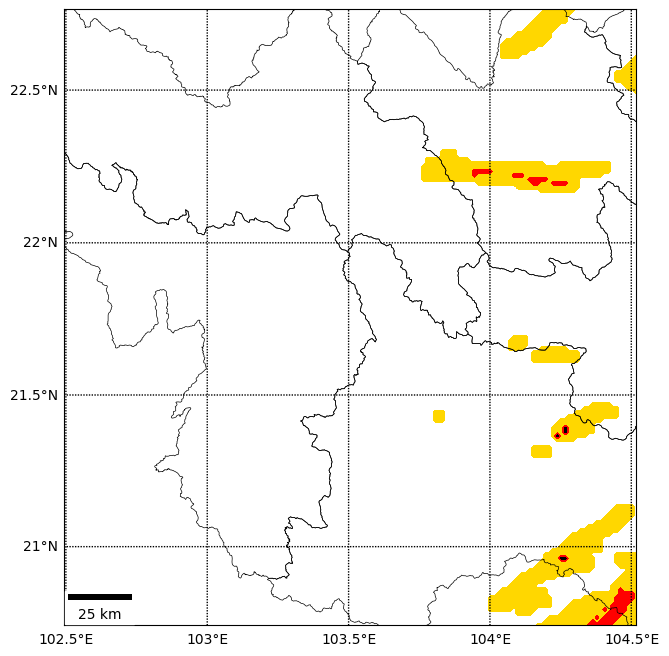

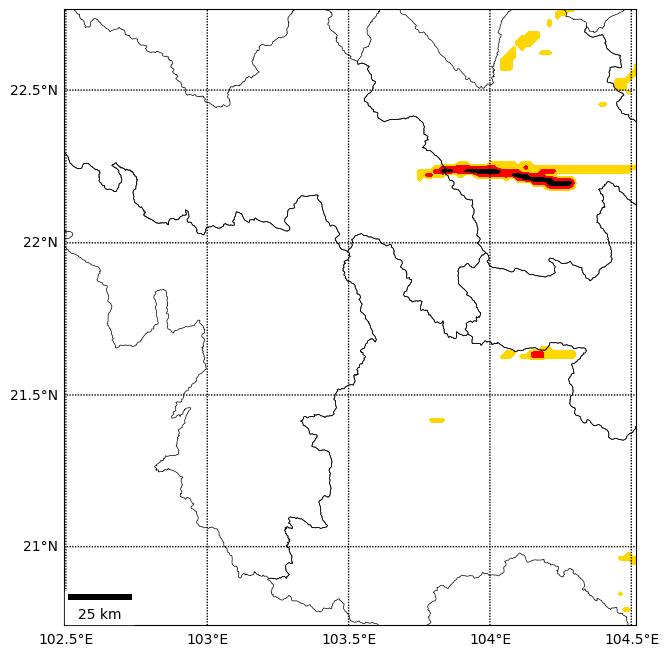

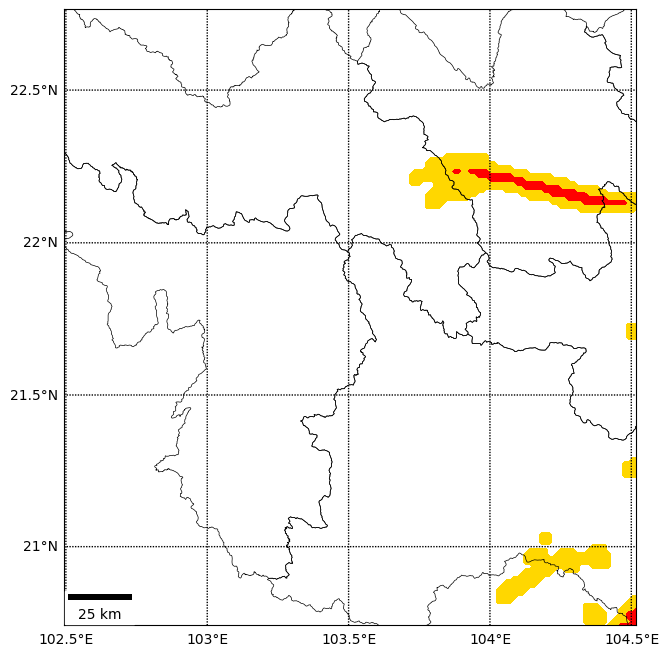

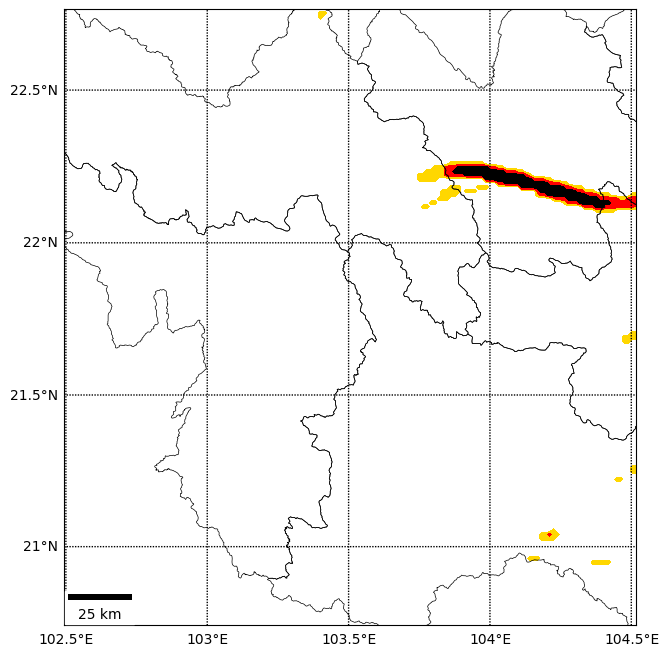

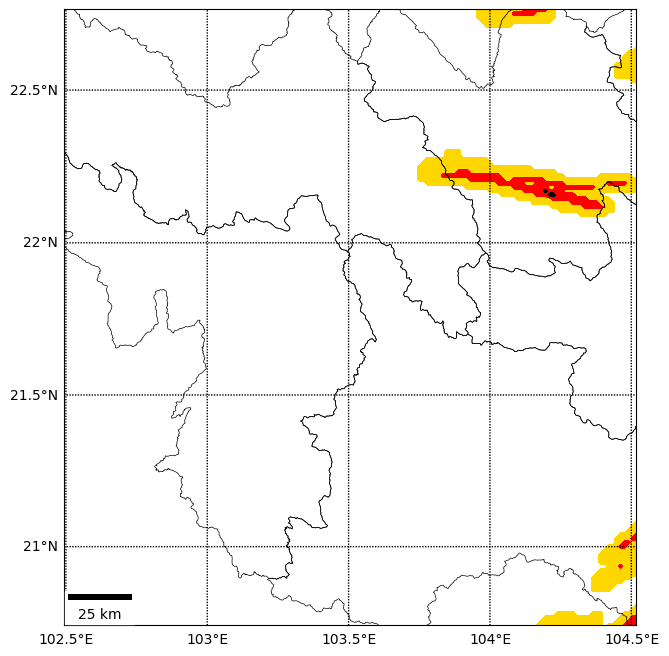

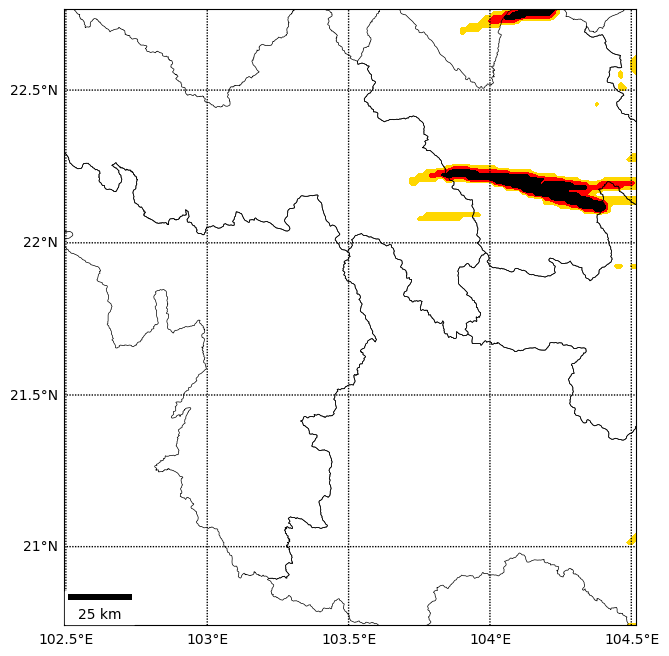

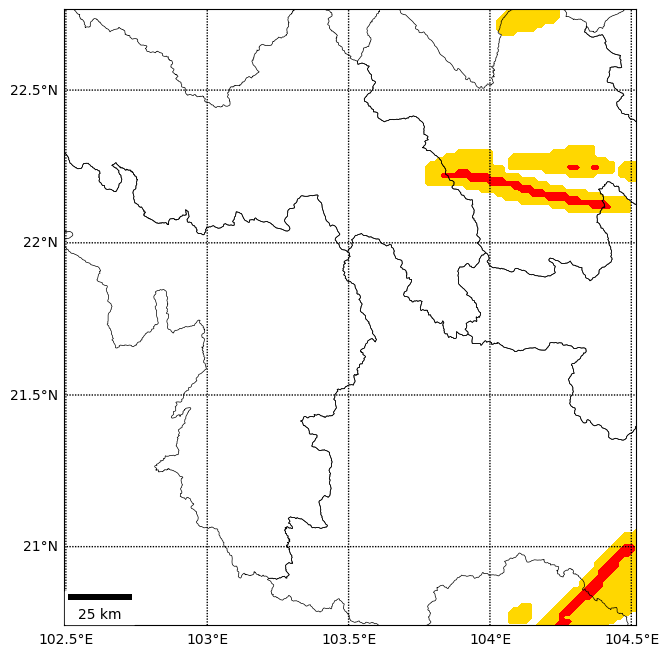

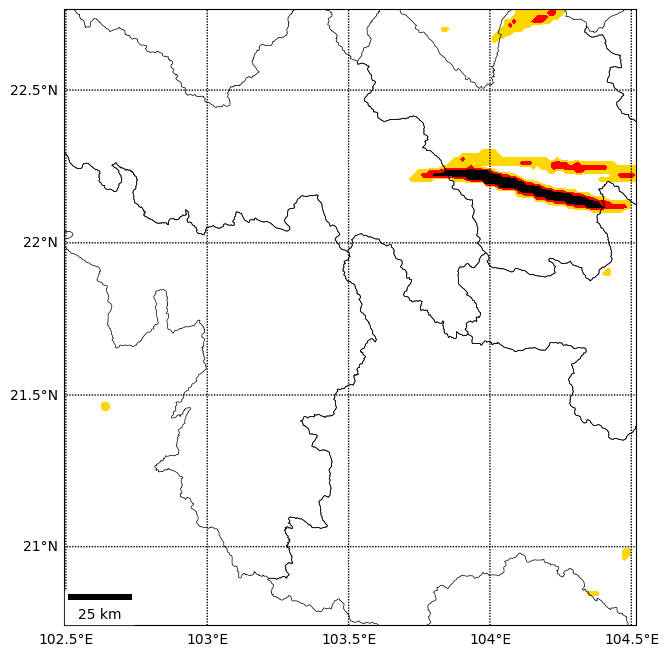

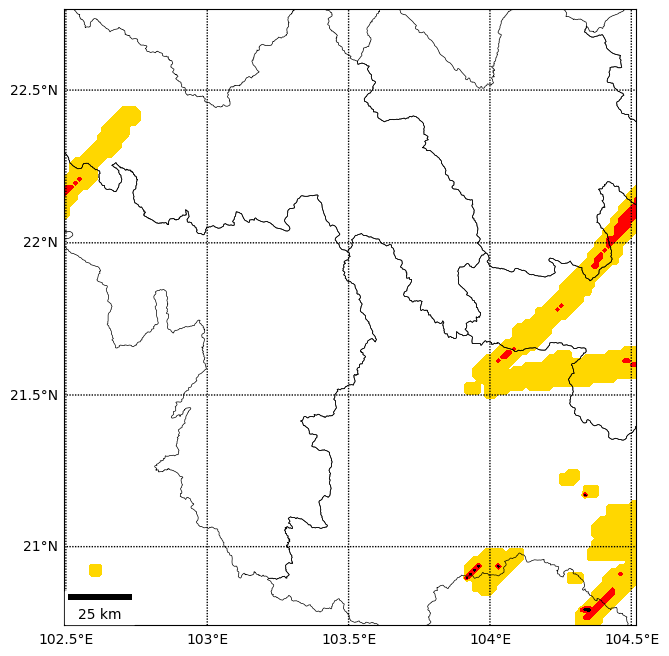

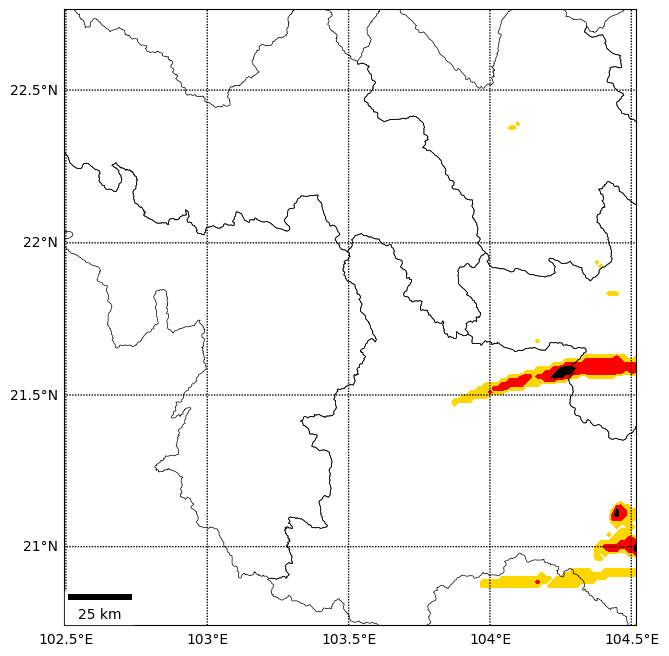

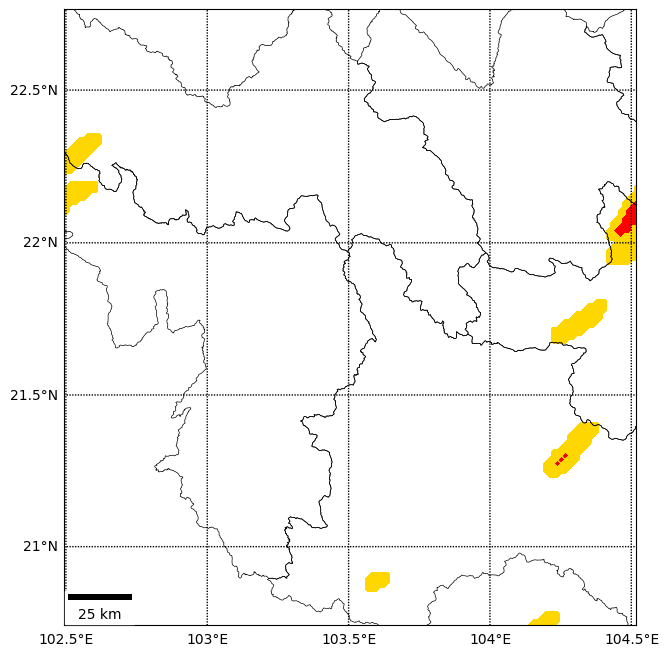

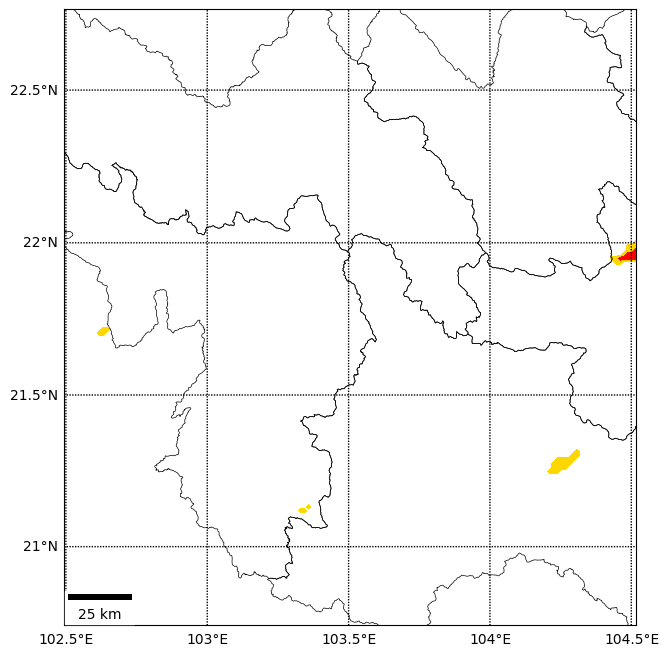

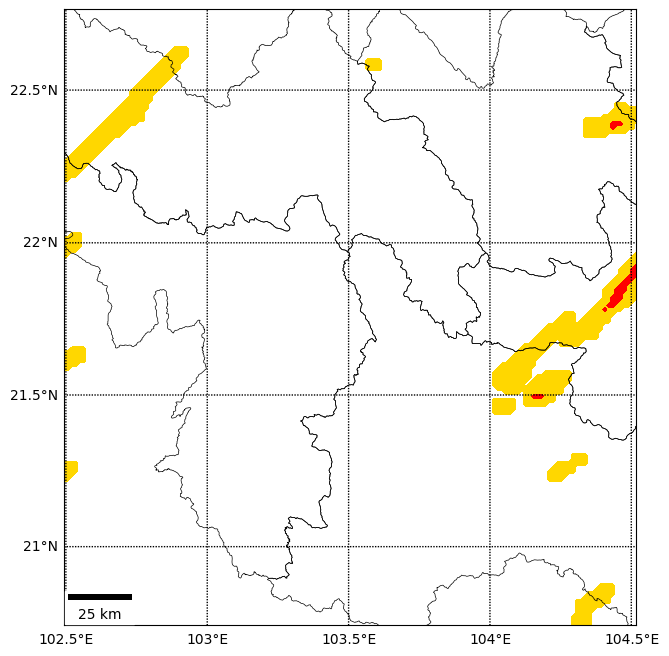

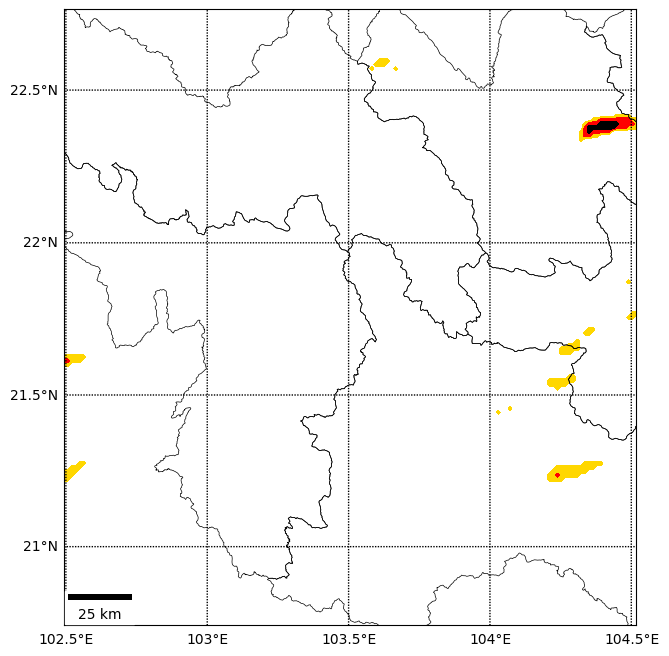

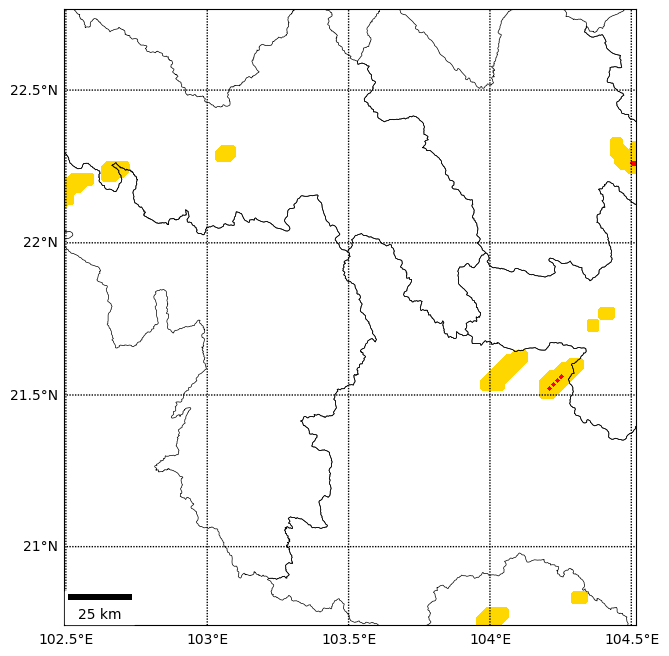

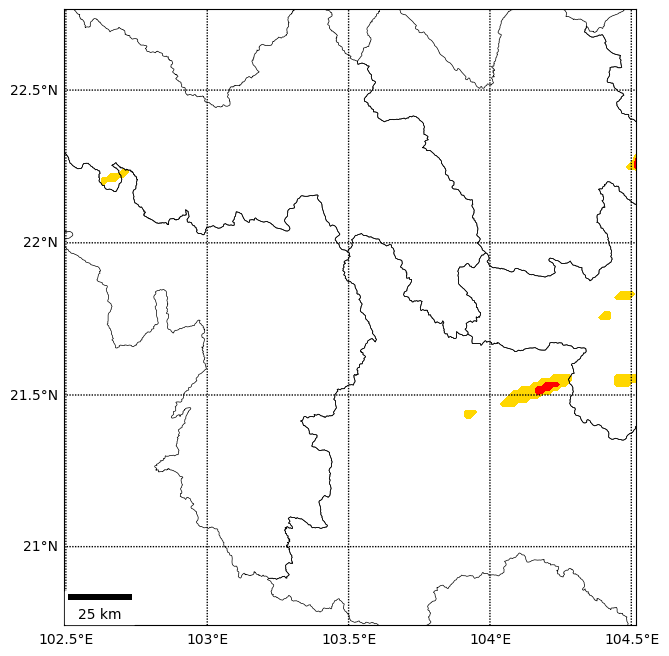

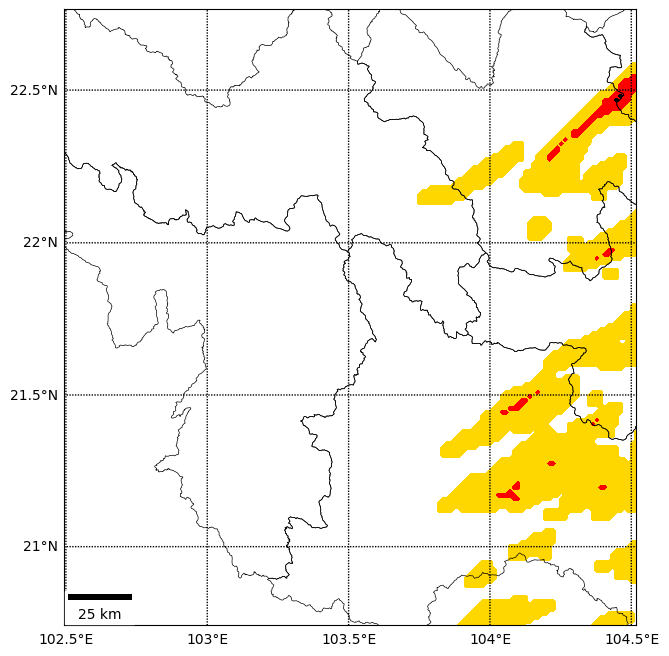

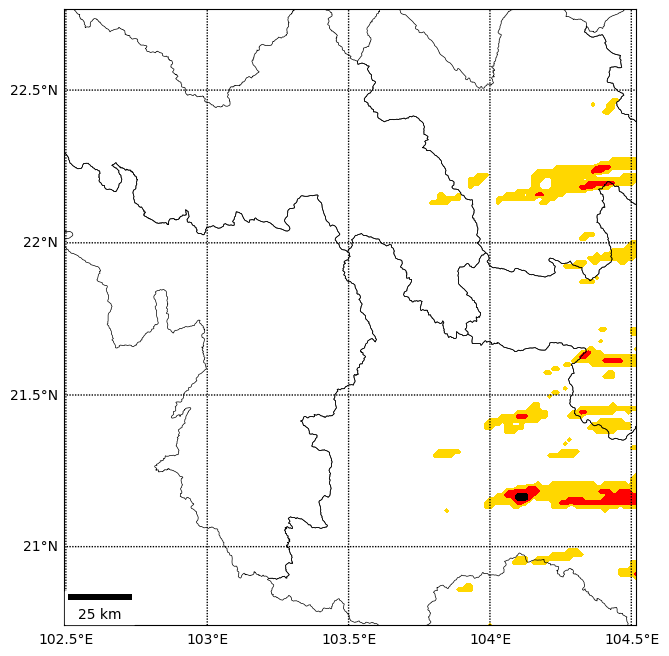

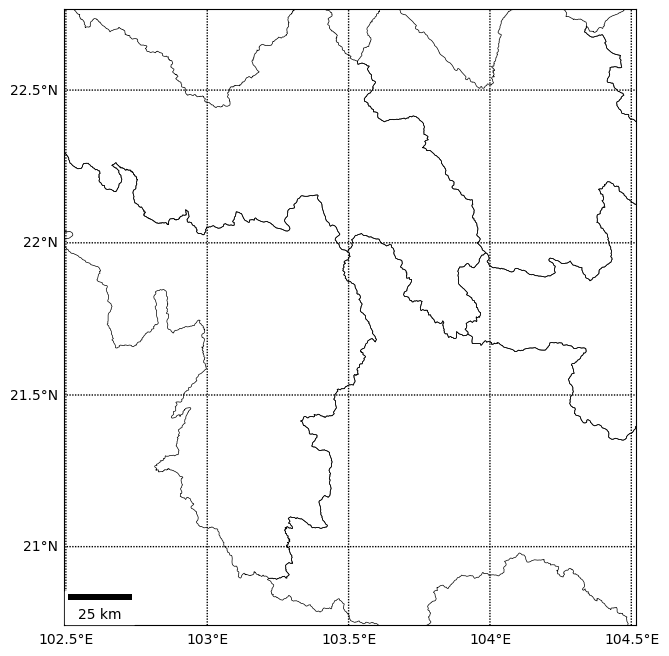

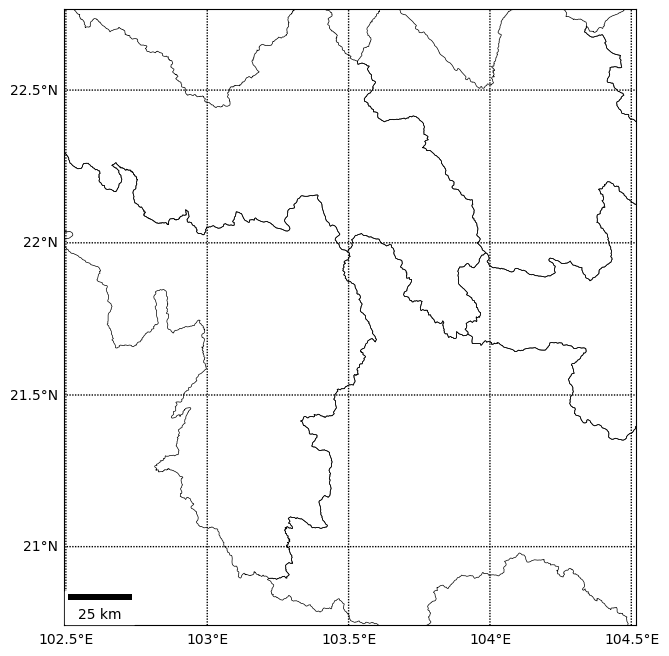

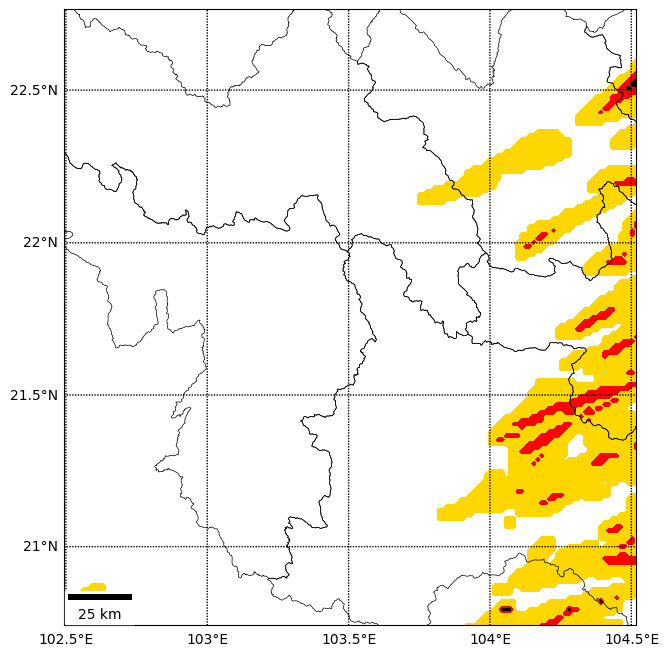

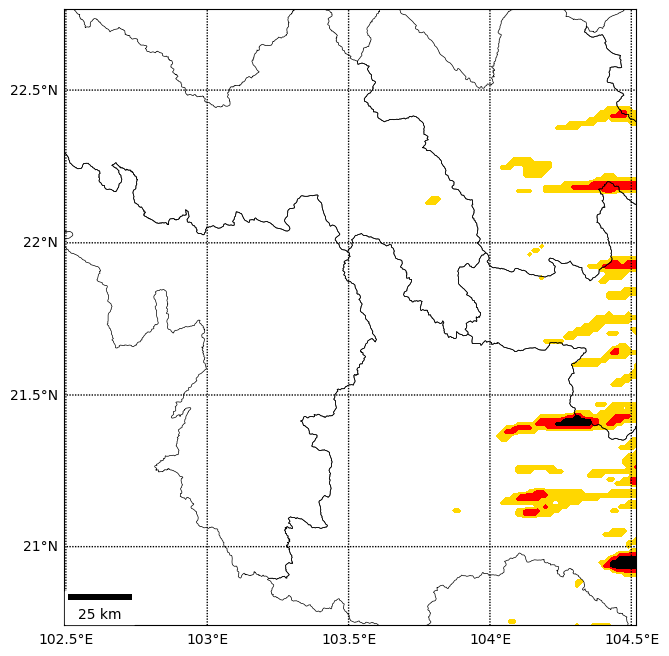

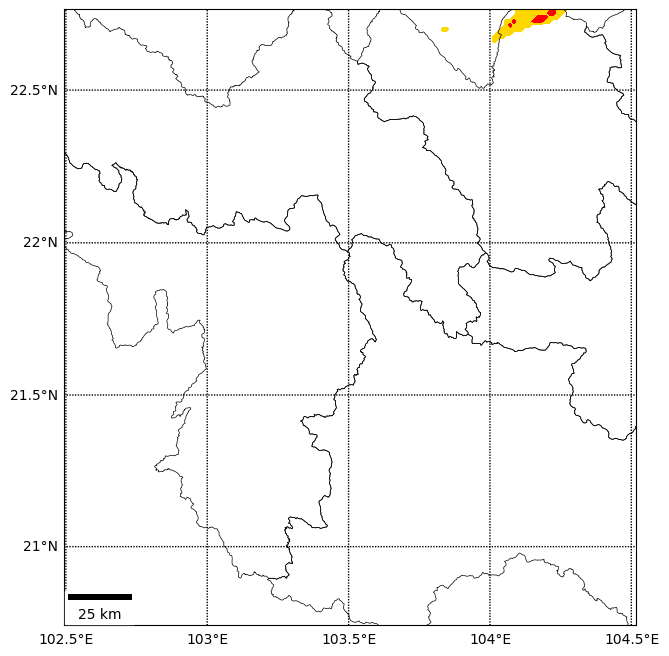

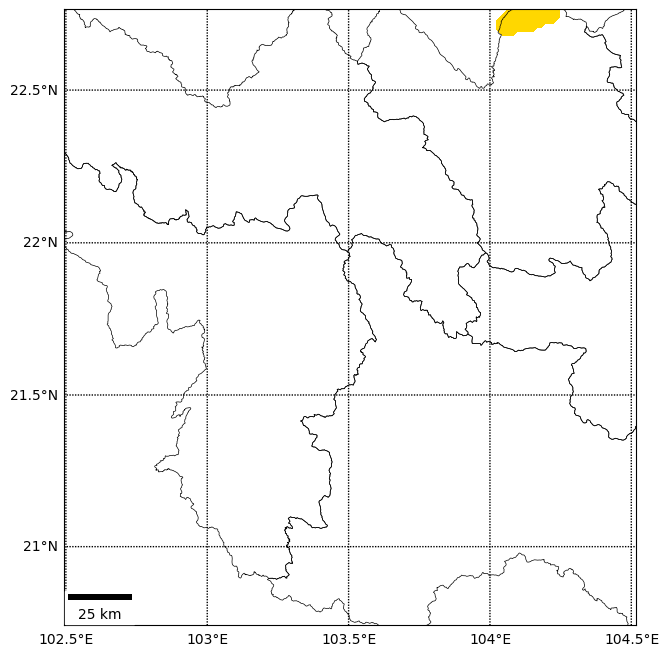

done


In [31]:
min_lat = lats[0,0]
min_lon = lons[0,0]
max_lat = lats[-1,-1]
max_lon = lons[-1,-1]

#print(m_HC.shape)
#print(lats[:,0])
#print(lons[0,:])

subplot_ncols = 1
subplot_nrows = 1
for case in range(1,4):
    for mpp in range(4):
        fig = plt.figure(figsize=[8,8])
        plt_binary(1,m_HC[case,mpp,:,:])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
        plt.show()
        fname = "HC.c" + str(case) + ".mp" + str(mpp) + ".png"
        fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
        plt.close()
        
        fig = plt.figure(figsize=[8,8])
        plt_binary(1,m_UH[case,mpp,:,:])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
        plt.show()
        fname = "UH.c" + str(case) + ".mp" + str(mpp) + ".png"
        fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
        plt.close()

print("done")

min_lat = lats[0,0]
min_lon = lons[0,0]
max_lat = lats[-1,-1]
max_lon = lons[-1,-1]

for mp0 in range(1):
        fig = plt.figure(figsize=[20,5])
        plt_binary(1,HSDA_mask[2,0,:,:])
        plt_binary(2,HSDA_max[2,0,:,:])
        
        plt.show()
        fname = "fi-mp"+str(mp0)+"_" + str(case) + "_all.png"
        #fig.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
        plt.close()

In [32]:
for duy in range(1):
    #sc_shape = [ 4, dhmax, nhour, len(scales) ]    # 4mp x (nhour-1) dh x nhour (12) hour x 120 scales

    score_uh = np.empty( [3, 4, len(scales)]) # 4case x 4mp x 121 scales
    score_hc = np.empty([3, 4, len(scales)])


    for mp00 in range(4):
        for case in range(3):             # lap cho tung khoang tgian
            #for nh in range(nhour - dh):     # lap cho tung gio
                score_uh_ = []
                score_hc_ = []
                for scale in scales:        # lap cho tung scale
                    score_uh_.append(fss(m_UH[case+1,mp00,:,:],
                                         m_HSDA[case+1,:,:], thr, scale))
                    score_hc_.append(fss(m_HC[case+1,mp00,:,:],
                                         m_HSDA[case+1,:,:], thr, scale))
                    
                score_uh[case,mp00,:] = score_uh_
                score_hc[case,mp00,:] = score_hc_
            
    FSS_HSDA_UH0 = np.asarray(score_uh)
    FSS_HSDA_HC0 = np.asarray(score_hc)
    
    FSS_HSDA_UH  = FSS_HSDA_UH0.mean(axis=0)
    FSS_HSDA_HC  = FSS_HSDA_HC0.mean(axis=0)
    

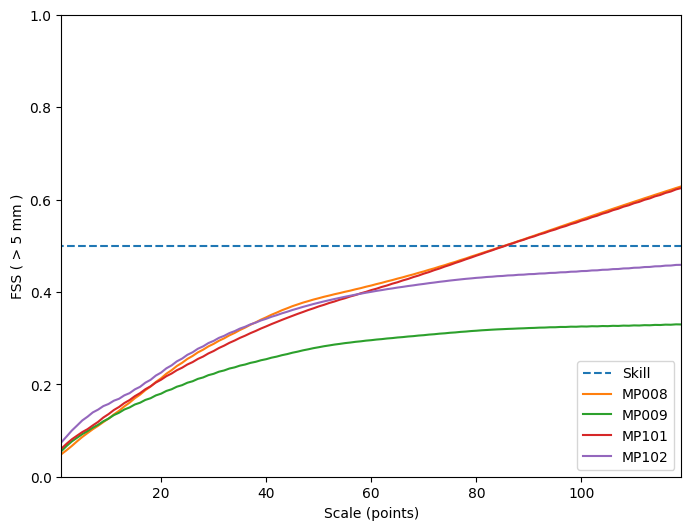

In [33]:
for h in range(1):
        mp00 = 0 # mp08 
        z = np.arange(120)
        # Hinh 1: Ve skill theo mot so gio HSDA
        Hinh1 = np.empty([ 5, 120 ])  #4mp + 1skillline x 120
        #h = 3 #12h + dh 
        Hinh1[0,:] = FSS_HSDA_UH[0,:]  #[mp00,:,h,:]
        Hinh1[1,:] = FSS_HSDA_UH[1,:]  #[mp00,:,h,:]
        Hinh1[2,:] = FSS_HSDA_UH[2,:]
        Hinh1[3,:] = 0.5*(FSS_HSDA_UH0[0,3,:] + FSS_HSDA_UH0[2,3,:])
        Hinh1[4,:] = 0.5 
        name = ["Skill", "MP008", "MP009", "MP101", "MP102"]
    #print(A4.shape)
        for i in range(1):
            plt.figure(figsize=(8,6))
            plt.ylim(0,1)
            plt.xlim(1,119)
            plt.plot(z,np.array(Hinh1[4,:]),linestyle='dashed')
            plt.plot(z,np.array(Hinh1[0:4,:]).T)
            plt.legend(name,  loc = "lower right")
            plt.xlabel("Scale (points)")
            plt.ylabel("FSS ( > 5 mm )")
            #plt.title("delta h "+str(h))
            #plt.title("Fractions skill score MP" + mp[case][mp0])
            fname = "UH.FSS.png"
            plt.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
            plt.show()
            plt.close()
    

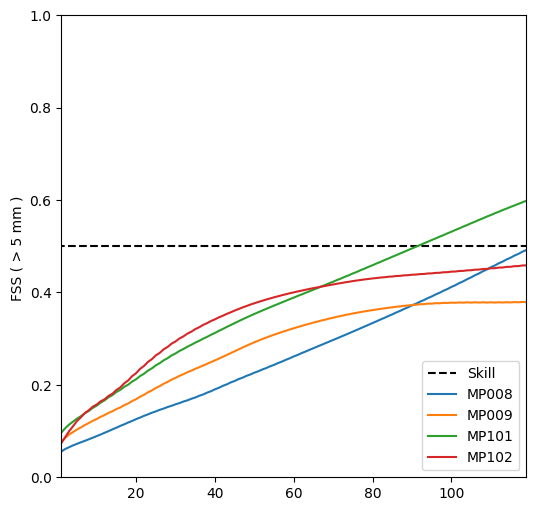

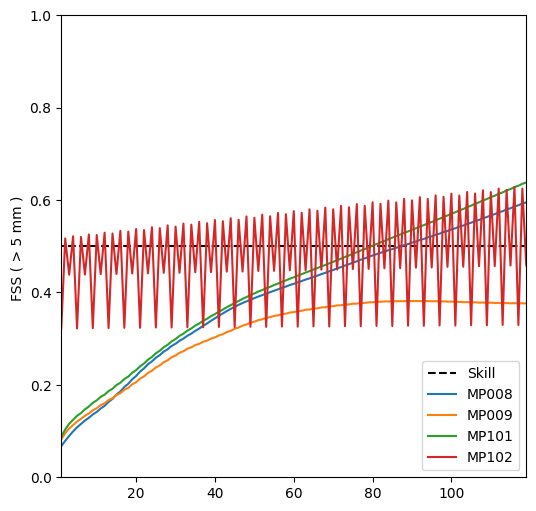

In [34]:
skill = np.empty([ 120 ])
skill[:] = 0.5
Hinh2 = np.empty([ 4, 120 ]) 
Hinh3 = np.empty([ 4, 120 ]) 

Hinh2[0,:] = 0.5*(FSS_HSDA_HC0[0,0,:] + FSS_HSDA_HC0[2,0,:])  #[mp00,:,h,:]
Hinh2[1,:] = 0.5*(FSS_HSDA_HC0[0,1,:] + FSS_HSDA_HC0[2,1,:])  #[mp00,:,h,:]
Hinh2[2,:] = 0.5*(FSS_HSDA_HC0[0,2,:] + FSS_HSDA_HC0[2,2,:])
Hinh2[3,:] = 0.5*(FSS_HSDA_HC0[0,3,:] + FSS_HSDA_HC0[2,3,:])

Hinh3[0,:] = 0.5*(FSS_HSDA_UH0[0,0,:] + FSS_HSDA_UH0[2,0,:])  #[mp00,:,h,:]
Hinh3[1,:] = 0.5*(FSS_HSDA_UH0[0,1,:] + FSS_HSDA_UH0[2,1,:])  #[mp00,:,h,:]
Hinh3[2,:] = 0.5*(FSS_HSDA_UH0[0,2,:] + FSS_HSDA_UH0[2,2,:])
Hinh2[3,:] = 0.5*(FSS_HSDA_UH0[0,3,:] + FSS_HSDA_UH0[2,3,:])

plt.figure(figsize=(6,6))
plt_fss(1,Hinh2.T,skill)
fname = "HC0.FSS.png"
plt.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.show()
plt.close()

plt.figure(figsize=(6,6))
plt_fss(1,Hinh3.T,skill)
fname = "UH0.FSS.png"
plt.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
plt.show()
plt.close()

plt.figure(figsize=(10,10))
plt_fss(1,Hinh1[0:4,:].T,skill)
fname = "UH2.FSS.png"
plt.savefig(fname,dpi=300, bbox_inches='tight',pad_inches=0.1)
#plt.show()
plt.close()

plt.figure(figsize=(10,10))
plt_fss(1,FSS_HSDA_UH.T,skill)
#plt.show()
plt.close()

plt.figure(figsize=(10,10))
plt_fss(1,FSS_HSDA_HC.T,skill)
#plt.show()
plt.close()

In [35]:
mp0 = 0
    idx = list(range(dhmax))
    plt_val = np.round(FSS_MESH_UH_dh[mp0,:,:],4)
    df = DataFrame(plt_val, index=idx, columns=scale2)
    norm = plt.Normalize(0,1)
    colours = plt.cm.hot_r(norm(plt_val))

    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

    the_table=plt.table(cellText=plt_val, rowLabels=df.index, colLabels=df.columns, 
                    #colWidths = [0.3]*plt_val.shape[1], 
                        loc='center', cellColours=colours)
    plt.show()

IndentationError: unexpected indent (160153351.py, line 2)